In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import tensorflow as tf
import ais
from priors import NormalPrior
from kernels import ParsenDensityEstimator
from functools import partial

seed = 31 # prime number is beautiful
tf.set_random_seed(seed)
np.random.seed(seed)

In [18]:
def avg_variance(p_gold, p_hat):
    """ statistics for comparing results"""
    return np.mean((p_gold - p_hat)**2)

## Consider a deterministic generator

- By setting a generator to be purely deterministic, we can view it as a perfect GAN. In the actual evaluation of GAN, since GAN does not decode the latent code to predict probability distribution for the observation, we need to associate with the GAN an *observation model*. Here I am using a Gaussian kernel density model, following the line of Wu et al.


- On the other hand, a deterministic generator associated with a Gaussian kernel density observation model can also be viewed as a VAE which gives identical observation variance for all the latent codes.


- A step further, we now have a spectrum: by controling the variance of the kernel, we can in fact make the deterministic generator vary between a VAE and a GAN. Concretely, higher kernel variance makes the generator more VAE and lower more GAN.

In [19]:
class Uni_Gaussian_Generator(object):
    """ This is a deterministic generator generates a unimodal gaussian, which maps: 
        z ~ N(0, 1^2) to x ~ N(mu, sigma^2) by z |-> z*sigma+mu """
    def __init__(self, input_dim, output_dim, mu, sigma):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mu = mu
        self.sigma = sigma

    def __call__(self, z):
        return z * self.sigma + self.mu

In [20]:
kernel = ParsenDensityEstimator() # observation model for p(x|z)
prior = NormalPrior() # the starting distribution of p(z) or q(z|x) in this case it is a N(0, 1^2)

### AIS vs Importance sampling: unmatched supports

By varying the mean of the generator away from the proposal distribution, we can compare AIS and Importance sampling with their abilities of handling unmatched supports.

In [26]:
def support_test(mu, sigma, kernel=kernel, prior=prior, num_samples=1000, plot=True, verbose=True, gather=False):
    """ run a test on unmatched supports """
    generator = Uni_Gaussian_Generator(1, 1, mu, sigma)
    model = ais.Model(generator,
                      prior,
                      kernel,
                      sigma=0.25, # used as variance parzen density obseration model, different sigma
                      num_samples=num_samples)

    # proposal distribution
    x_pps = np.linspace(norm.ppf(0.01, loc=0, scale=1), norm.ppf(0.99, loc=0, scale=1), 100)
    p_pps = norm.pdf(x_pps, loc=0, scale=1)
    
    # generate sample points
    x = np.linspace(norm.ppf(0.01, loc=mu, scale=sigma), norm.ppf(0.99, loc=mu, scale=sigma), 100)
    xx = np.reshape(x, [100, 1])

    # gold density
    p_gold = norm.pdf(x, loc=mu, scale=sigma)

    # importance sampling estimation
    imp_schedule = ais.get_schedule(1, rad=4)
    p_imp = np.exp(model.ais(xx, imp_schedule))

    # AIS sampling estimation
    ais_schedule = ais.get_schedule(100, rad=4)
    p_ais = np.exp(model.ais(xx, ais_schedule))

    # compute and compare variances
    variance_imp = avg_variance(p_gold, p_imp)
    variance_ais = avg_variance(p_gold, p_ais)
    reduction_ratio = 100 * variance_ais/variance_imp
    
    # print statistics
    if verbose:
        print('avg variance')
        print('\timportance sampling: %0.6f'%variance_imp)
        print('\tAIS sampling: %0.6f'%variance_ais)
        print('\nvariance ratio')
        print('\t%0.2f%%'%reduction_ratio)

    # plot
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(x_pps, p_pps, '--', label='proposal density')
        ax.plot(x, p_gold, 'y', label='gold density')
        ax.plot(x, p_imp,'c',label='importance sampling estimation')
        ax.plot(x, p_ais,'m',label='AIS sampling estimation')
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
        ax.grid()
        plt.show()
        
    # gather statistics, 
    if gather:
        return variance_ais, variance_imp, reduction_ratio

#### plot: mu = 3, sigma = 1

avg variance
	importance sampling: 0.000161
	AIS sampling: 0.000120

variance ratio
	74.27%


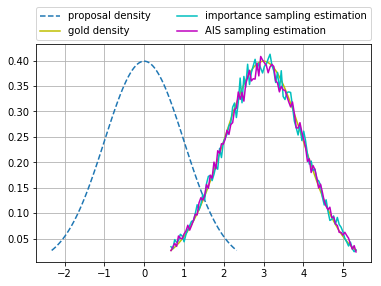

In [29]:
mu = 3
sigma = 1
support_test(mu, sigma)

#### plot: mu = 5, sigma = 1

avg variance
	importance sampling: 0.000279
	AIS sampling: 0.000123

variance ratio
	43.92%


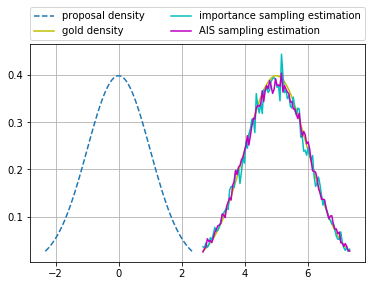

In [34]:
mu = 5
sigma = 1
support_test(mu, sigma)

#### gather statistics

In [12]:
def experiment_runner(mu_s, sigma_s, num_runs, test):
    for mu in mu_s:
        for sigma in sigma_s:
            avg_ais, avg_imp, avg_ratio = 0.0, 0.0, 0.0
            print('runing on mu=%d, sigma=%d' % (mu, sigma))
            for i in range(num_runs):
                print(i, end=' ')
                ret = test(mu, sigma, plot=False, verbose=False, gather=True)
                avg_ais += ret[0]
                avg_imp += ret[1]
                avg_ratio += np.log(ret[2])
            avg_ais /= num_runs
            avg_imp /= num_runs
            avg_ratio = np.exp(avg_ratio/num_runs)
            print('\n*** avg_ais: %0.6f\tavg_imp: %0.6f\tavg_ratio: %0.6f ***' % (avg_ais, avg_imp, avg_ratio))

In [14]:
mu_s = [0, 2, 4, 6, 8]
sigma_s = [1]
num_runs = 10

experiment_runner(mu_s, sigma_s, num_runs, support_test)

runing on mu=0, sigma=1
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000126	avg_imp: 0.000202	avg_ratio: 62.722929 ***
runing on mu=2, sigma=1
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000141	avg_imp: 0.000211	avg_ratio: 66.333316 ***
runing on mu=4, sigma=1
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000132	avg_imp: 0.000228	avg_ratio: 57.813227 ***
runing on mu=6, sigma=1
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000127	avg_imp: 0.000208	avg_ratio: 61.491705 ***
runing on mu=8, sigma=1
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000146	avg_imp: 0.000233	avg_ratio: 62.221028 ***


### AIS vs Importance sampling: #chains

#### plot: #chains=100

avg variance
	importance sampling: 0.001998
	AIS sampling: 0.000929

variance ratio
	46.50%


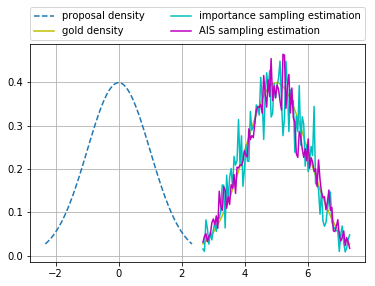

In [31]:
mu = 5
sigma = 1

support_test(mu, sigma, num_samples=100)

#### gather statistics

In [32]:
mu = 5
sigma = 1
num_runs = 10

ns_test = partial(support_test, mu=mu, sigma=sigma, plot=False, verbose=False, gather=True)
for num_samples in [50, 100, 200, 500, 1000]:
    avg_ais, avg_imp, avg_ratio = 0.0, 0.0, 0.0
    print('running on #chains=%d' % num_samples)
    for i in range(num_runs):
        print(i, end=' ')
        ret = ns_test(num_samples=num_samples)
        avg_ais += ret[0]
        avg_imp += ret[1]
        avg_ratio += np.log(ret[2])
    avg_ais /= num_runs
    avg_imp /= num_runs
    avg_ratio = np.exp(avg_ratio/num_runs)
    print('\n*** avg_ais: %0.6f\tavg_imp: %0.6f\tavg_ratio: %0.6f ***' % (avg_ais, avg_imp, avg_ratio))ns_test = partial(support_test, mu=mu, sigma=sigma, plot=False, verbose=False, gather=True)
for num_samples in [50, 100, 200, 500, 1000]:
    avg_ais, avg_imp, avg_ratio = 0.0, 0.0, 0.0
    print('running on #chains=%d' % num_samples)
    for i in range(num_runs):
        print(i, end=' ')
        ret = ns_test(num_samples=num_samples)
        avg_ais += ret[0]
        avg_imp += ret[1]
        avg_ratio += np.log(ret[2])
    avg_ais /= num_runs
    avg_imp /= num_runs
    avg_ratio = np.exp(avg_ratio/num_runs)
    print('\n*** avg_ais: %0.6f\tavg_imp: %0.6f\tavg_ratio: %0.6f ***' % (avg_ais, avg_imp, avg_ratio))

running on #chains=50
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.001782	avg_imp: 0.003235	avg_ratio: 54.886275 ***
running on #chains=100
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000893	avg_imp: 0.001677	avg_ratio: 53.914442 ***
running on #chains=200
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000507	avg_imp: 0.000925	avg_ratio: 54.803618 ***
running on #chains=500
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000231	avg_imp: 0.000404	avg_ratio: 56.667871 ***
running on #chains=1000
0 1 2 3 4 5 6 7 8 9 
*** avg_ais: 0.000136	avg_imp: 0.000201	avg_ratio: 67.478278 ***


### VAE vs GAN

As mentioned above, by controling the variance of the kernel, we can in fact make the deterministic generator vary between a VAE and a GAN.

In [37]:
def kernel_test(mu, sigma, kernel=kernel, prior=prior, num_samples=1000, plot=True, verbose=True, gather=False, kernel_sigma=0.25):
    """ run a test on unmatched supports """
    generator = Uni_Gaussian_Generator(1, 1, mu, sigma)
    model = ais.Model(generator,
                      prior,
                      kernel,
                      sigma=kernel_sigma, # used as variance parzen density obseration model, different sigma
                      num_samples=num_samples)

    # proposal distribution
    x_pps = np.linspace(norm.ppf(0.01, loc=0, scale=1), norm.ppf(0.99, loc=0, scale=1), 100)
    p_pps = norm.pdf(x_pps, loc=0, scale=1)
    
    # generate sample points
    x = np.linspace(norm.ppf(0.01, loc=mu, scale=sigma), norm.ppf(0.99, loc=mu, scale=sigma), 100)
    xx = np.reshape(x, [100, 1])

    # gold density
    p_gold = norm.pdf(x, loc=mu, scale=sigma)

    # importance sampling estimation
    imp_schedule = ais.get_schedule(1, rad=4)
    p_imp = np.exp(model.ais(xx, imp_schedule))

    # AIS sampling estimation
    ais_schedule = ais.get_schedule(100, rad=4)
    p_ais = np.exp(model.ais(xx, ais_schedule))

    # compute and compare variances
    variance_imp = avg_variance(p_gold, p_imp)
    variance_ais = avg_variance(p_gold, p_ais)
    reduction_ratio = 100 * variance_ais/variance_imp
    
    # print statistics
    if verbose:
        print('avg variance')
        print('\timportance sampling: %0.6f'%variance_imp)
        print('\tAIS sampling: %0.6f'%variance_ais)
        print('\nvariance ratio')
        print('\t%0.2f%%'%reduction_ratio)

    # plot
    if plot:
        fig, ax = plt.subplots(1, 1)
        ax.plot(x_pps, p_pps, '--', label='proposal density')
        ax.plot(x, p_gold, 'y', label='gold density')
        ax.plot(x, p_imp,'c',label='importance sampling estimation')
        ax.plot(x, p_ais,'m',label='AIS sampling estimation')
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
        ax.grid()
        plt.show()
        
    # gather statistics, 
    if gather:
        return variance_ais, variance_imp, reduction_ratio

#### plot: test with small kernel sigma = 0.01

avg variance
	importance sampling: 0.005392
	AIS sampling: 0.000540

variance ratio
	10.02%


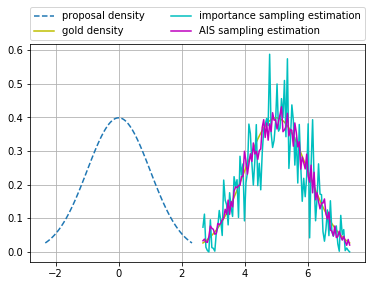

In [38]:
mu = 5
sigma = 1
kernel_sigma = 0.01

kernel_test(mu, sigma, kernel_sigma=kernel_sigma)

#### plot: test with large kernel sigma = 0.8

In [ ]:
mu = 5
sigma = 1
kernel_sigma = 0.8

kernel_test(mu, sigma, kernel_sigma=kernel_sigma)

#### gather statistics

In [40]:
mu = 10
sigma = 2
num_runs = 5
kernel_sigma_s = [0.01, 0.05, 0.1, 0.25, 0.4, 0.6]

for kernel_sigma in kernel_sigma_s:
    avg_ais, avg_imp, avg_ratio = 0.0, 0.0, 0.0
    print('running on kernel_sigma=%f' % kernel_sigma)
    for i in range(num_runs):
        print(i, end=' ')
        ret = kernel_test(mu, sigma, plot=False, verbose=False, gather=True, kernel_sigma=kernel_sigma)
        avg_ais += ret[0]
        avg_imp += ret[1]
        avg_ratio += np.log(ret[2])
    avg_ais /= num_runs
    avg_imp /= num_runs
    avg_ratio = np.exp(avg_ratio/num_runs)
    print('\n*** avg_ais: %0.6f\tavg_imp: %0.6f\tavg_ratio: %0.6f ***' % (avg_ais, avg_imp, avg_ratio))

running on kernel_sigma=0.010000
0 1 2 3 4 
*** avg_ais: 0.000303	avg_imp: 0.003229	avg_ratio: 9.541065 ***
running on kernel_sigma=0.050000
0 1 2 3 4 
*** avg_ais: 0.000084	avg_imp: 0.000533	avg_ratio: 16.175977 ***
running on kernel_sigma=0.100000
0 1 2 3 4 
*** avg_ais: 0.000049	avg_imp: 0.000310	avg_ratio: 15.807980 ***
running on kernel_sigma=0.250000
0 1 2 3 4 
*** avg_ais: 0.000039	avg_imp: 0.000113	avg_ratio: 34.937318 ***
running on kernel_sigma=0.400000
0 1 2 3 4 
*** avg_ais: 0.000030	avg_imp: 0.000064	avg_ratio: 46.871307 ***
running on kernel_sigma=0.600000
0 1 2 3 4 
*** avg_ais: 0.000042	avg_imp: 0.000058	avg_ratio: 71.417804 ***
running on kernel_sigma=0.800000
0 

KeyboardInterrupt: 

### The effect of observation model & AIS mode capture

- Peaked/skewed modes. If we make the generator's variance smaller, it means the target distribution is more peaked, which is a common situation in high dimensional space.


- It turns out this experiment leads to further consideration of the effect of observational model. Since when the mode is peaked at some point, the observation model may have a variance comparable with the "radius" of the mode, this will drastically affect the accuracy. This should happen often in high dimensional space especially if different dimensions carry semantically independent information, and the mode will skewed along some dimension but flat on the others.

#### plot: peaked mode with sigma = 0.4

avg variance
	importance sampling: 0.006860
	AIS sampling: 0.006681

variance ratio
	97.40%


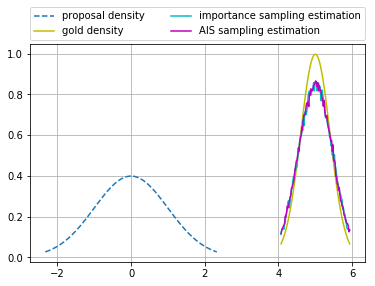

In [33]:
mu = 5
sigma = 0.4
support_test(mu, sigma)

#### gather statistics

In [ ]:
mu_s = [8]
sigma_s = [0.2 0.8 1 2]
num_runs = 10

experiment_runner(mu_s, sigma_s, num_runs, support_test)